In [1]:
import geopandas as gpd
import pandas as pd

import folium
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib import colors

import seaborn as sns

In [2]:
property_df = pd.read_parquet("../../data/raw/property_details_w_distances.parquet")
suburbs_gdf = gpd.read_parquet('../../data/curated/suburb_shapefile_w_postcodes.parquet')

property_gdf = gpd.GeoDataFrame(
    property_df, geometry=gpd.points_from_xy(property_df.longitude, property_df.latitude), crs="EPSG:4326"
)

# Reproject both GeoDataFrames to the same CRS (WGS84 is what Folium uses)
suburbs_gdf = suburbs_gdf.to_crs(epsg=4326)
property_gdf = property_gdf.to_crs(epsg=4326)

# Check if everything loaded correctly
property_gdf.head()
suburbs_gdf.head()

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,postcode
0,lcp-ejVyte1DxXx,locb0dcb52a6b55,2023-06-26,Abbeyard,Gazetted Locality,VIC,"POLYGON ((146.65061 -36.94496, 146.68449 -36.9...",3737
1,lcp386f2bcf9bce,locb9872f35df41,2021-06-24,Abbotsford,Gazetted Locality,VIC,"POLYGON ((144.99137 -37.80959, 144.99254 -37.8...",3067
2,lcprFRP2-cPMfr5,loc8123ed12ea8d,2023-03-21,Aberfeldie,Gazetted Locality,VIC,"POLYGON ((144.88854 -37.75546, 144.88854 -37.7...",3040
3,lcpj3KHi-vakgFj,loc1eb4a229104a,2023-12-10,Aberfeldy,Gazetted Locality,VIC,"POLYGON ((146.35535 -37.69944, 146.35751 -37.6...",3825
4,lcpoO-hq-yZZASg,locb17be87767e1,2023-12-10,Acheron,Gazetted Locality,VIC,"POLYGON ((145.638 -37.28417, 145.64233 -37.279...",3714


In [3]:
# Calculate centroid of the properties to center the map
centroid = property_gdf.geometry.centroid
center_lat = centroid.y.mean()
center_lon = centroid.x.mean()

# Create a base Folium map centered on the mean coordinates
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Prepare the heatmap data: [latitude, longitude, price]
heat_data = [[row['geometry'].y, row['geometry'].x, row['price']] for index, row in property_gdf.iterrows()]

# Add the heatmap to the folium map
HeatMap(heat_data, radius=10, blur=15, max_zoom=10).add_to(m)

m

/tmp/ipykernel_16441/2743098247.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = property_gdf.geometry.centroid


In [4]:
property_counts = property_df.groupby('postcode').size().reset_index(name='property_count')
suburbs_gdf = suburbs_gdf.merge(property_counts, on='postcode', how='left')

suburbs_gdf['property_count'] = suburbs_gdf['property_count'].fillna(0)
suburbs_gdf['size'] = suburbs_gdf['property_count']

average_price = property_df.groupby('postcode')['price'].mean().reset_index(name='avg_price')
suburbs_gdf = suburbs_gdf.merge(average_price, on='postcode', how='left')

suburbs_gdf['avg_price'] = suburbs_gdf['avg_price'].fillna(0)

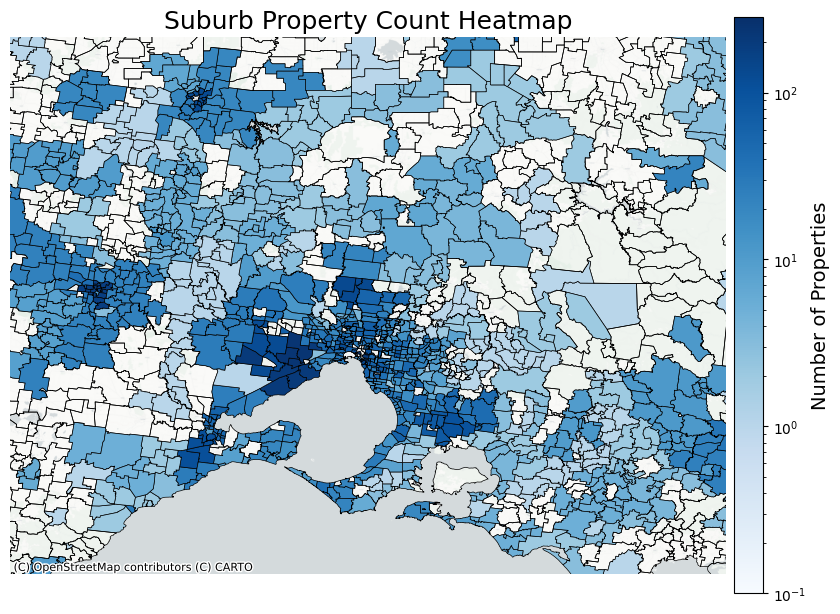

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_xlim([143.5, 146.5])
ax.set_ylim([-38.75, -36.5])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

vmin, vmax = 0.1, suburbs_gdf['size'].max()
cmap = 'Blues'
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

ax = suburbs_gdf.plot(column='size', linewidth=0.5, edgecolor='black', 
                      cmap=cmap, legend=False, ax=ax, norm=norm)


ctx.add_basemap(ax, crs=suburbs_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

ax.set_title('Suburb Property Count Heatmap', fontsize=18)

ax.set_axis_off()

patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.01)
cb.ax.set_ylabel('Number of Properties', fontsize=14)

plt.show()

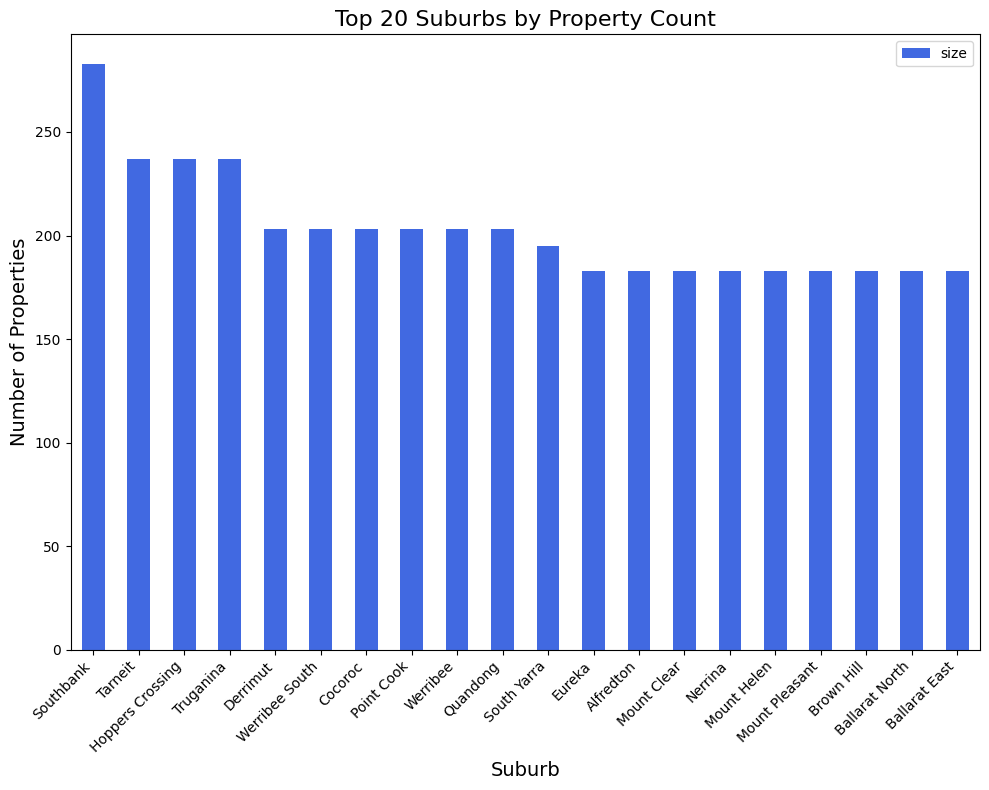

In [6]:
# Sort the suburbs GeoDataFrame by property count ('size') and select top 20 suburbs
top_suburbs = suburbs_gdf[['LOC_NAME', 'size']].sort_values(by='size', ascending=False).head(20)

# Create a bar plot for the top 20 suburbs
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the top 20 suburbs by property count
top_suburbs.plot(kind='bar', x='LOC_NAME', y='size', ax=ax, color='royalblue')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Number of Properties', fontsize=14)
ax.set_title('Top 20 Suburbs by Property Count', fontsize=16)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(top_suburbs['LOC_NAME'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

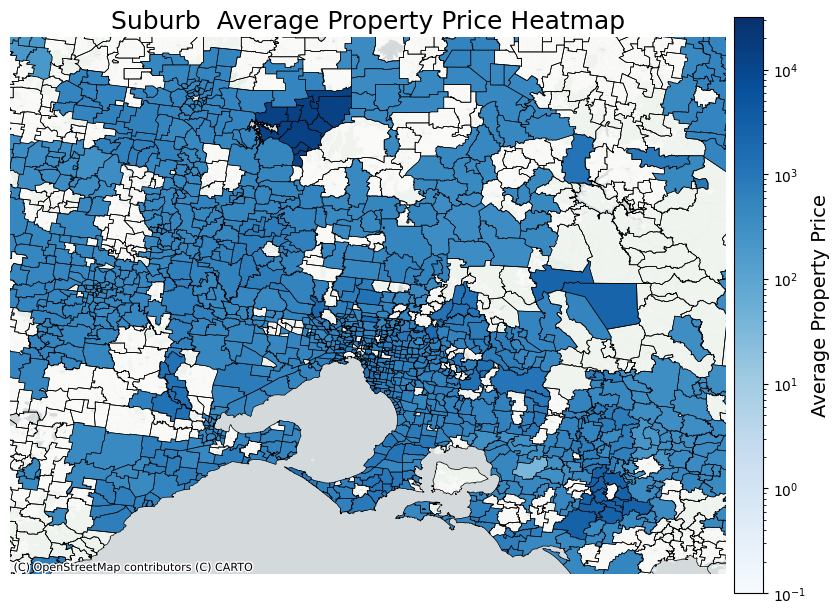

In [7]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_xlim([143.5, 146.5])
ax.set_ylim([-38.75, -36.5])

# Adjust the figure layout for better spacing
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

# Set minimum and maximum for the color range (without LogNorm)
vmin, vmax = 0.1, suburbs_gdf['avg_price'].max()
cmap = 'Blues'
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the suburbs data, colored by the 'avg_price' column
ax = suburbs_gdf.plot(column='avg_price', linewidth=0.5, edgecolor='black', 
                      cmap=cmap, legend=False, ax=ax, norm=norm)


# Add the basemap again after setting the limits
ctx.add_basemap(ax, crs=suburbs_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# Set the title of the map
ax.set_title('Suburb  Average Property Price Heatmap', fontsize=18)

# Remove the axes for a cleaner look
ax.set_axis_off()

# Add a colorbar to show the range of values
patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.01)
cb.ax.set_ylabel('Average Property Price', fontsize=14)

# Display the plot
plt.show()

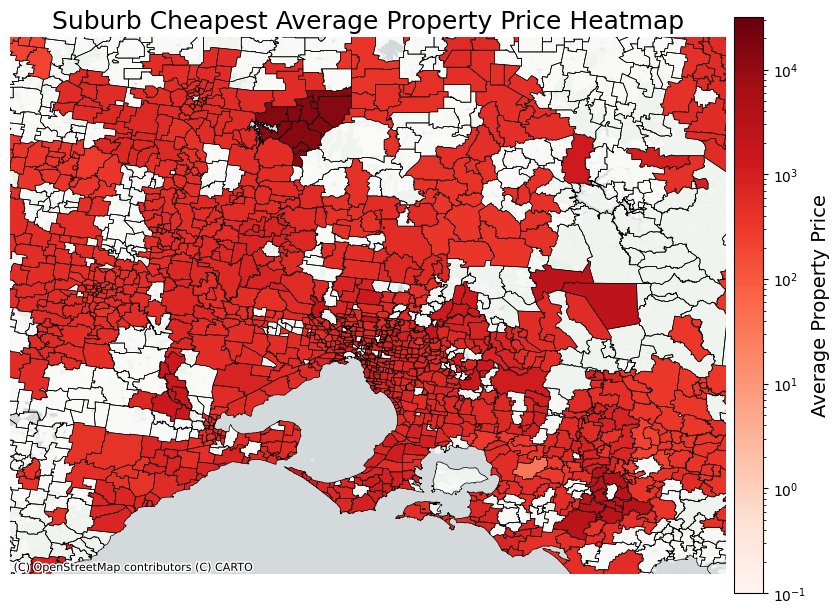

In [9]:
# Calculate the average property price per suburb
# Assuming 'avg_price' is already calculated in 'suburbs_gdf'
# Sort the dataframe by avg_price to highlight the cheapest suburbs
suburbs_gdf = suburbs_gdf.sort_values(by='avg_price', ascending=True)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Set geographical limits (adjust these to fit your map properly)
ax.set_xlim([143.5, 146.5])
ax.set_ylim([-38.75, -36.5])

# Adjust the figure layout for better spacing
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

# Set the color map to 'Reds' to highlight cheapest suburbs
vmin, vmax = 0.1, suburbs_gdf['avg_price'].max()  # Keep vmax same to ensure color scaling
cmap = 'Reds'  # Change to Reds for highlighting low values
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the suburbs data, colored by the 'avg_price' column
ax = suburbs_gdf.plot(column='avg_price', linewidth=0.5, edgecolor='black', 
                      cmap=cmap, legend=False, ax=ax, norm=norm)

# Add the basemap again after setting the limits
ctx.add_basemap(ax, crs=suburbs_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# Set the title of the map
ax.set_title('Suburb Cheapest Average Property Price Heatmap', fontsize=18)

# Remove the axes for a cleaner look
ax.set_axis_off()

# Add a colorbar to show the range of values
patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.01)
cb.ax.set_ylabel('Average Property Price', fontsize=14)

# Display the plot
plt.show()


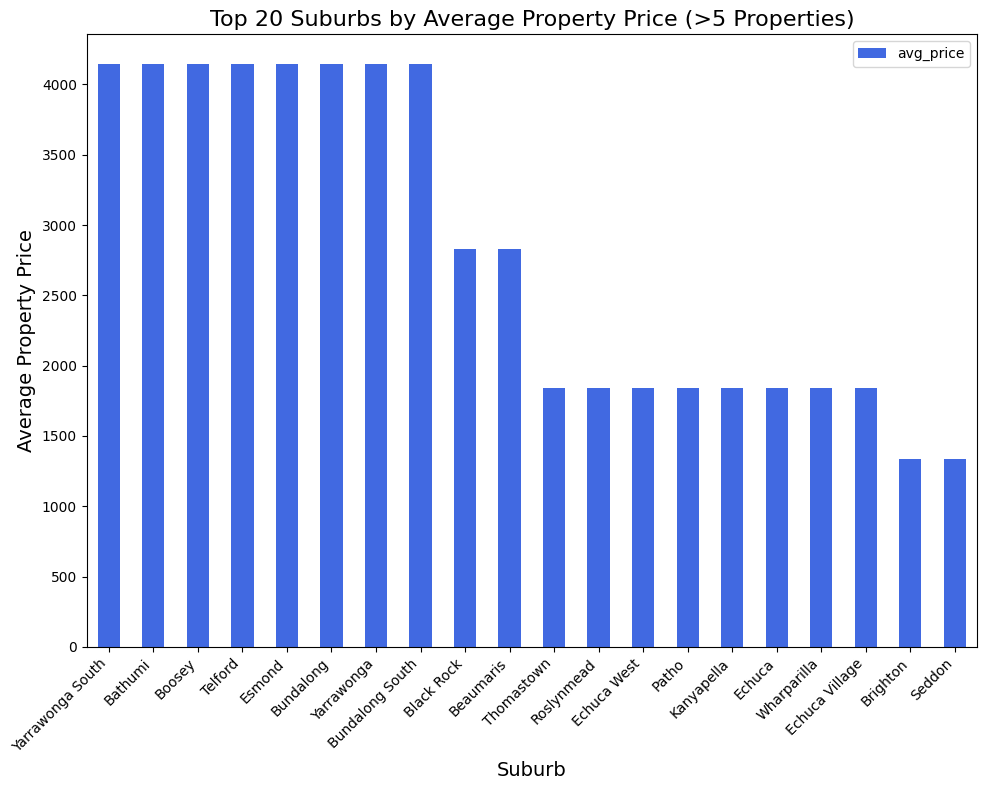

In [8]:
# Filter suburbs that have at least 10 properties, then sort by average price
top_price_suburbs = suburbs_gdf[suburbs_gdf['property_count'] >= 10][['LOC_NAME', 'avg_price']].sort_values(by='avg_price', ascending=False).head(20)

# Create a bar plot for the top 20 suburbs by average price
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the top 20 suburbs by property price
top_price_suburbs.plot(kind='bar', x='LOC_NAME', y='avg_price', ax=ax, color='royalblue')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Average Property Price', fontsize=14)
ax.set_title('Top 20 Suburbs by Average Property Price (>5 Properties)', fontsize=16)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(top_price_suburbs['LOC_NAME'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


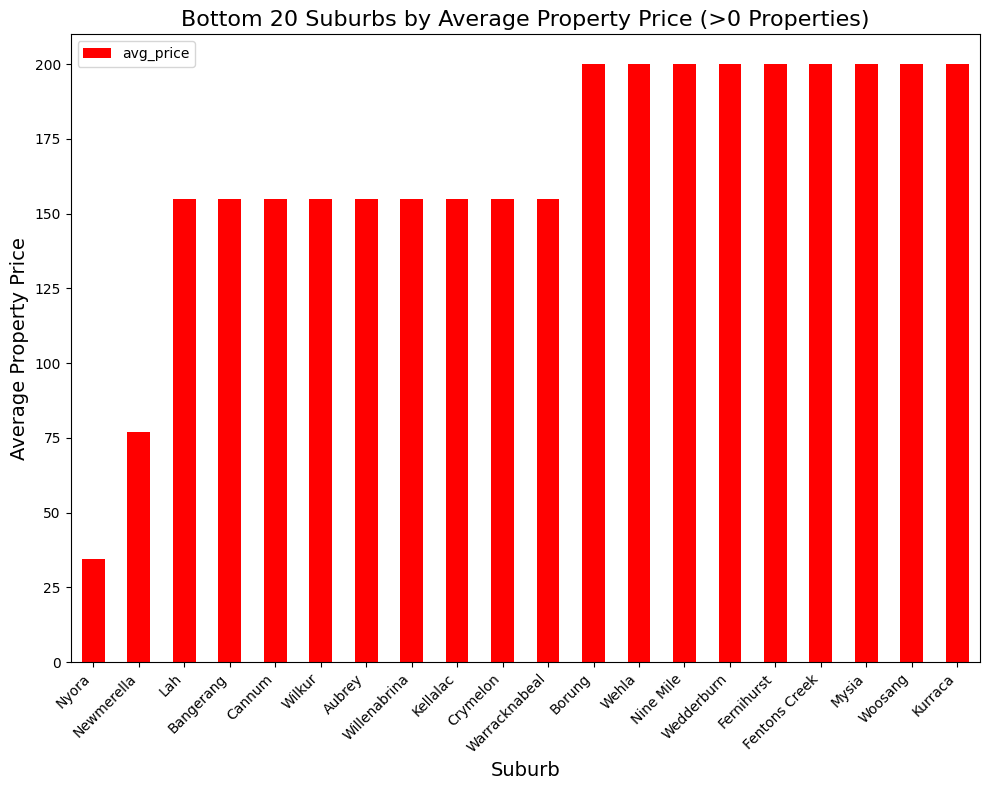

In [14]:
# Filter suburbs that have at least 1 property, then sort by average price (ascending)
bottom_price_suburbs = suburbs_gdf[suburbs_gdf['property_count'] > 0][['LOC_NAME', 'avg_price']].sort_values(by='avg_price', ascending=True).head(20)

# Create a bar plot for the bottom 20 suburbs by average price
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the bottom 20 suburbs by property price
bottom_price_suburbs.plot(kind='bar', x='LOC_NAME', y='avg_price', ax=ax, color='red')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Average Property Price', fontsize=14)
ax.set_title('Bottom 20 Suburbs by Average Property Price (>0 Properties)', fontsize=16)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(bottom_price_suburbs['LOC_NAME'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


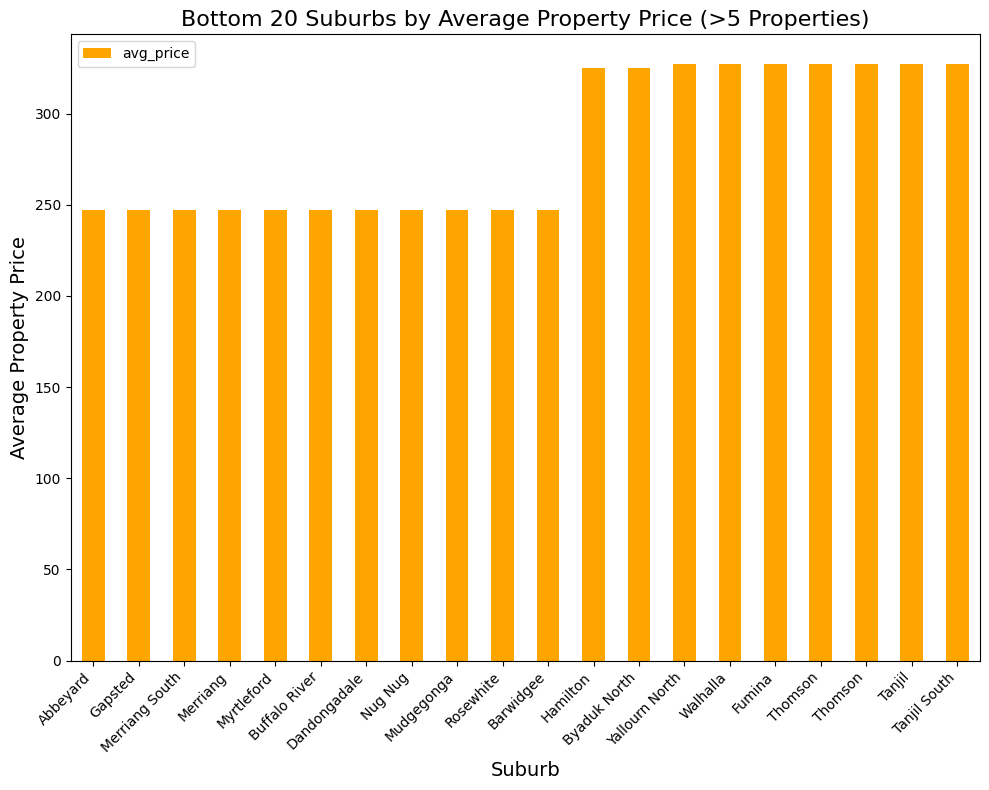

In [9]:
# Filter suburbs that have at least 10 properties, then sort by average price
top_price_suburbs = suburbs_gdf[suburbs_gdf['property_count'] >= 5][['LOC_NAME', 'avg_price']].sort_values(by='avg_price', ascending=True).head(20)

# Create a bar plot for the top 20 suburbs by average price
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the top 20 suburbs by property price
top_price_suburbs.plot(kind='bar', x='LOC_NAME', y='avg_price', ax=ax, color='orange')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Average Property Price', fontsize=14)
ax.set_title('Bottom 20 Suburbs by Average Property Price (>5 Properties)', fontsize=16)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(top_price_suburbs['LOC_NAME'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


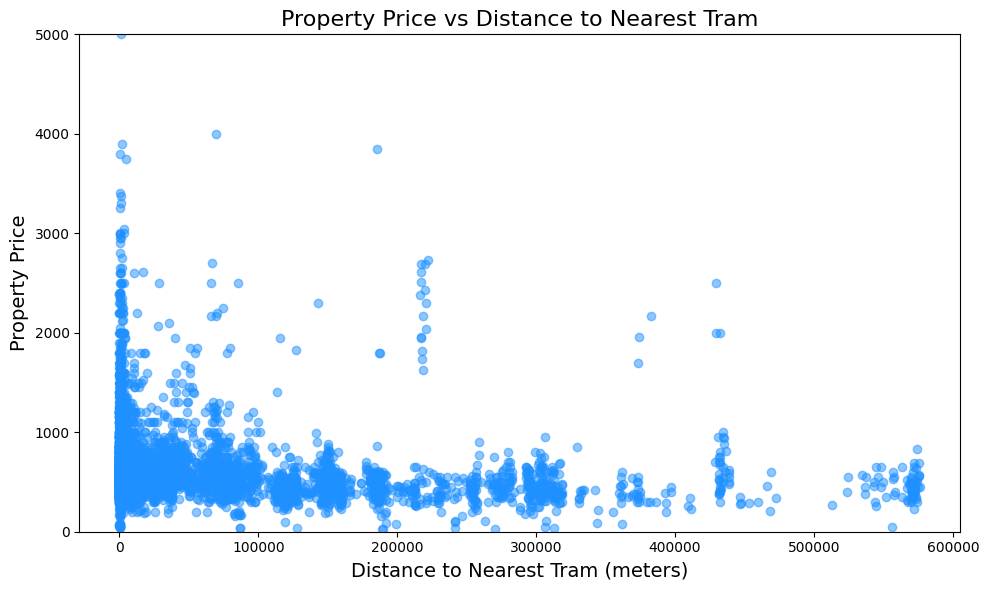

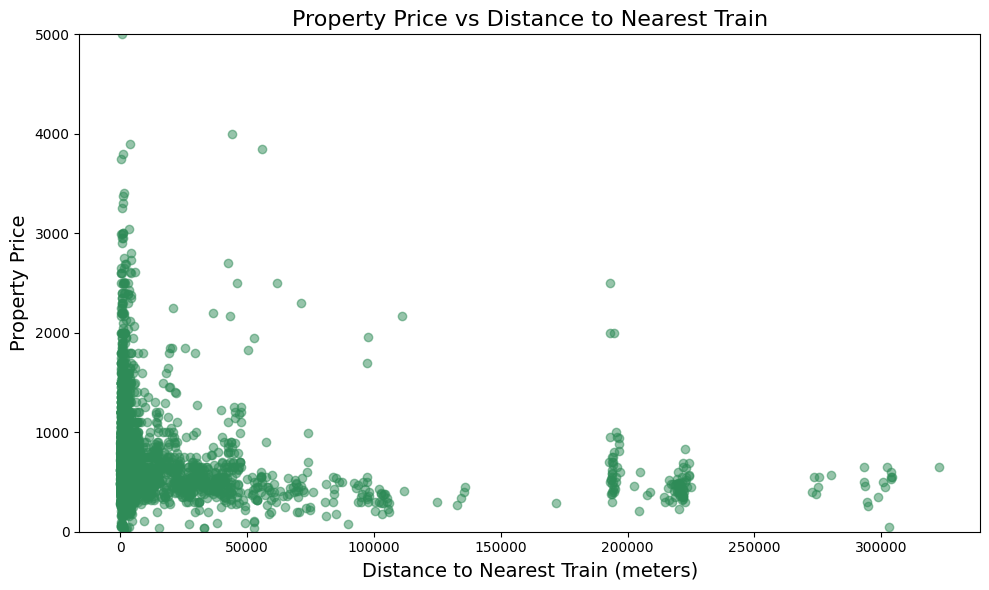

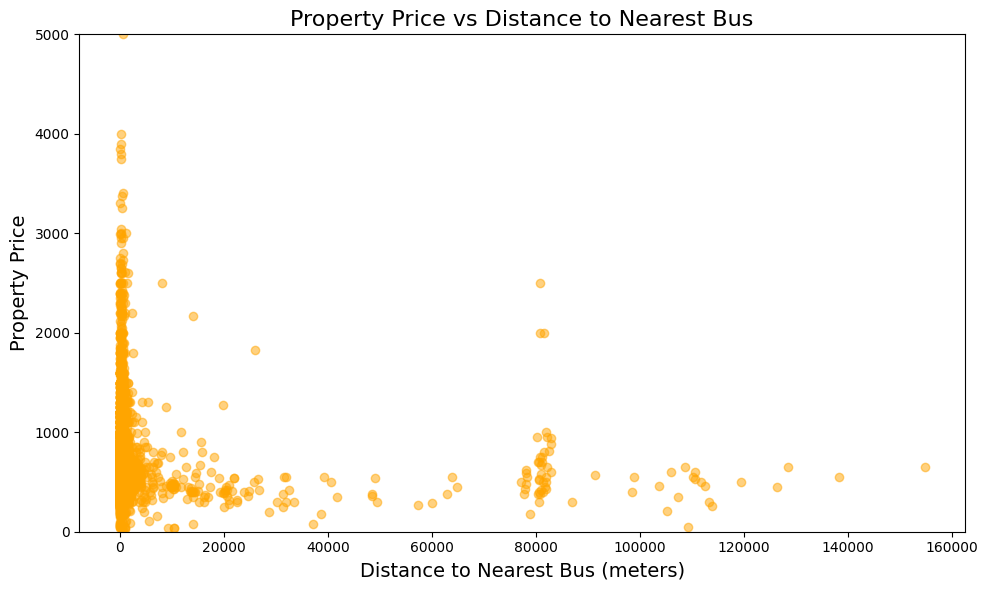

In [10]:
# Scatter plot: Price vs Distance to Tram
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['distance_to_closest_tram'], property_df['price'], alpha=0.5, color='dodgerblue')
ax.set_xlabel('Distance to Nearest Tram (meters)', fontsize=14)
ax.set_ylabel('Property Price', fontsize=14)
ax.set_title('Property Price vs Distance to Nearest Tram', fontsize=16)
plt.tight_layout()
plt.show()

# Similarly, you can do for Train and Bus
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['distance_to_closest_train'], property_df['price'], alpha=0.5, color='seagreen')
ax.set_xlabel('Distance to Nearest Train (meters)', fontsize=14)
ax.set_ylabel('Property Price', fontsize=14)
ax.set_title('Property Price vs Distance to Nearest Train', fontsize=16)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['distance_to_closest_bus'], property_df['price'], alpha=0.5, color='orange')
ax.set_xlabel('Distance to Nearest Bus (meters)', fontsize=14)
ax.set_ylabel('Property Price', fontsize=14)
ax.set_title('Property Price vs Distance to Nearest Bus', fontsize=16)
plt.tight_layout()
plt.show()

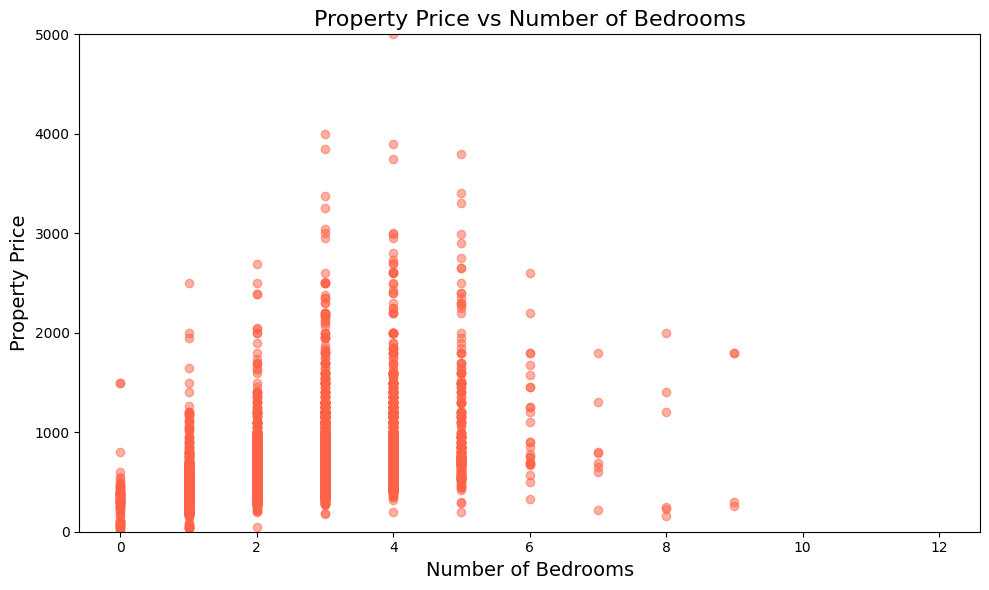

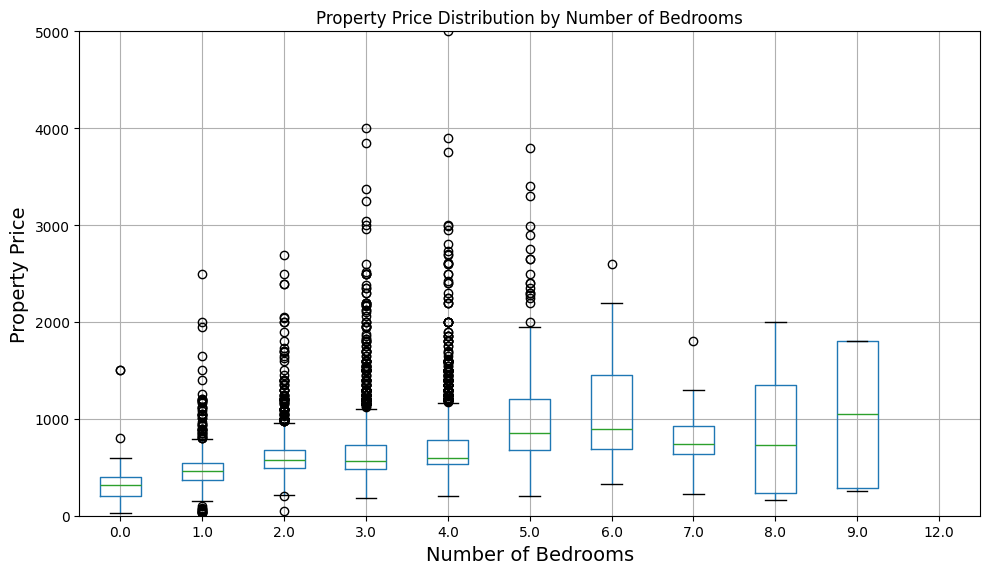

In [11]:
# Scatter plot: Price vs Number of Bedrooms
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['bedrooms'], property_df['price'], alpha=0.5, color='tomato')
ax.set_xlabel('Number of Bedrooms', fontsize=14)
ax.set_ylabel('Property Price', fontsize=14)
ax.set_title('Property Price vs Number of Bedrooms', fontsize=16)
plt.tight_layout()
plt.show()

# Alternatively, you can use a box plot if you want to summarize price by bedrooms
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
property_df.boxplot(column='price', by='bedrooms', ax=ax)
ax.set_xlabel('Number of Bedrooms', fontsize=14)
ax.set_ylabel('Property Price', fontsize=14)
ax.set_title('Property Price Distribution by Number of Bedrooms')
plt.suptitle('')  # Suppress the automatic title
plt.tight_layout()
plt.show()


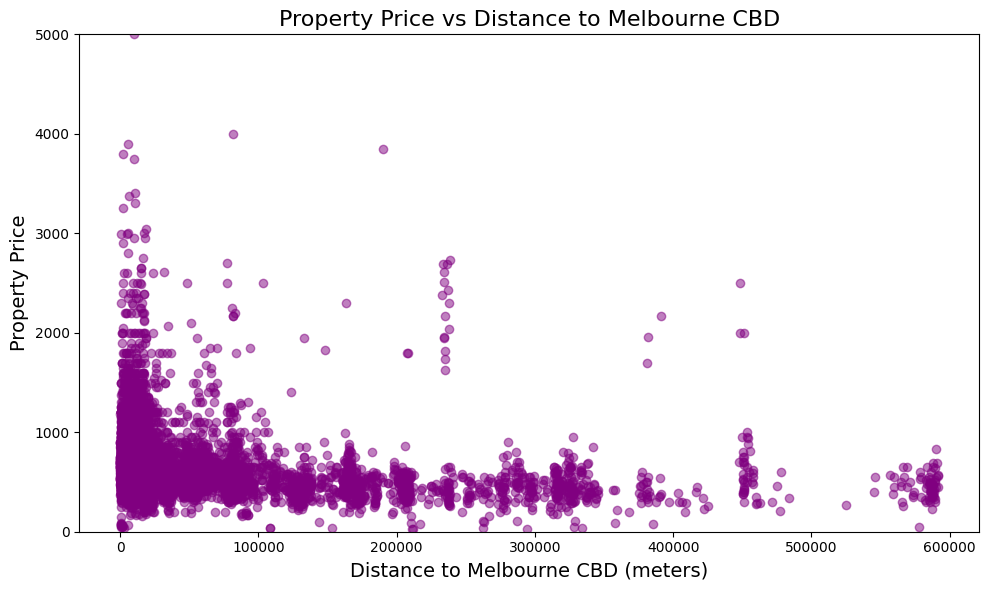

In [12]:
# Scatter plot: Price vs Distance to Melbourne CBD
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['distance_to_melbourne_cbd'], property_df['price'], alpha=0.5, color='purple')
ax.set_xlabel('Distance to Melbourne CBD (meters)', fontsize=14)
ax.set_ylabel('Property Price', fontsize=14)
ax.set_title('Property Price vs Distance to Melbourne CBD', fontsize=16)
plt.tight_layout()
plt.show()

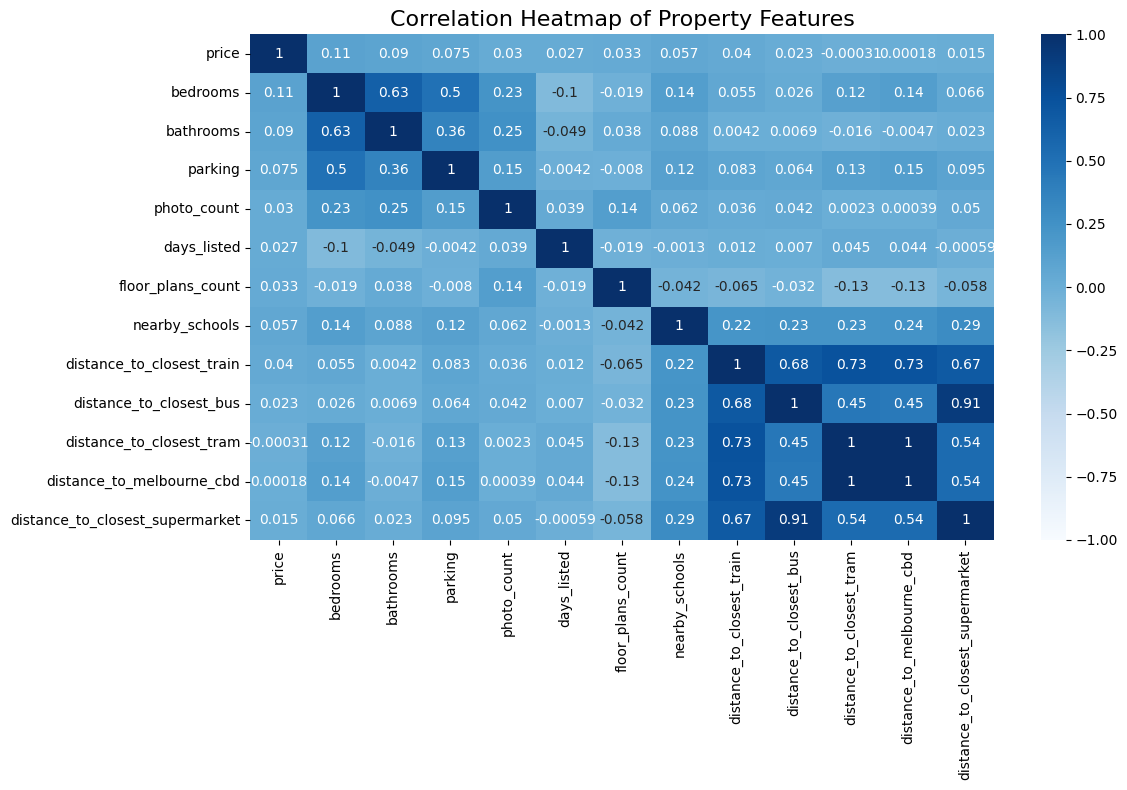

In [13]:
columns_to_drop = ['title', 'description', 'street_address', 'suburb', 'postcode', 
                   'primary_property_type', 'structured_features', 'video_count',
                   'date_listed', 'virtual_tour', 'latitude', 'longitude']

numeric_df = property_df.drop(columns=columns_to_drop)

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, center=0)

plt.title('Correlation Heatmap of Property Features', fontsize=16)

plt.tight_layout()
plt.show()